In [2]:
# https://docs.exoplanet.codes/en/stable/tutorials/transit/

xoplanet includes methods for computing the light curves transiting planets. 
In its simplest form this can be used to evaluate a light curve like you would do with batman, for example:

In [3]:
import pymc3 
import pymc3_ext 

pymc3.__version__


'3.11.2'

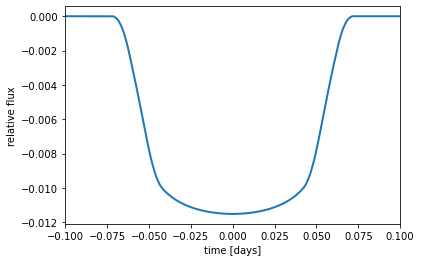

In [4]:
#print("Section 001: ")

import numpy as np
import matplotlib.pyplot as plt

import exoplanet as xo

# The light curve calculation requires an orbit
orbit = xo.orbits.KeplerianOrbit(period=3.456)

# Compute a limb-darkened light curve using starry
t = np.linspace(-0.1, 0.1, 1000)
u = [0.3, 0.2]
light_curve = (
    xo.LimbDarkLightCurve(*u)
    .get_light_curve(orbit=orbit, r=0.1, t=t, texp=0.02)
    .eval()
)
# Note: the `eval` is needed because this is using Theano in
# the background

plt.plot(t, light_curve, color="C0", lw=2)
plt.ylabel("relative flux")
plt.xlabel("time [days]")
_ = plt.xlim(t.min(), t.max())

But the real power comes from the fact that this is defined as a Theano operation so it can be combined with PyMC3 to do transit inference using Hamiltonian Monte Carlo.

The transit model in PyMC3
In this section, we will construct a simple transit fit model using PyMC3 and then we will fit a two planet model to simulated data. To start, let’s randomly sample some periods and phases and then define the time sampling:


In [5]:
np.random.seed(123)
periods = np.random.uniform(5, 20, 2)
t0s = periods * np.random.rand(2)
t = np.arange(0, 80, 0.02)
yerr = 5e-4

Then, define the parameters. In this simple model, we’ll just fit for the limb darkening parameters of the star, and the period, phase, impact parameter, and radius ratio of the planets (note: this is already 10 parameters and running MCMC to convergence using emcee would probably take at least an hour). For the limb darkening, we’ll use a quadratic law as parameterized by Kipping (2013). This reparameterizations is implemented in exoplanet as custom PyMC3 distribution exoplanet.distributions.QuadLimbDark.

In [6]:
import pymc3 as pm
import pymc3_ext as pmx

with pm.Model() as model:

    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=1.0)

    # The time of a reference transit for each planet
    t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=2)

    # The log period; also tracking the period itself
    logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=2)
    period = pm.Deterministic("period", pm.math.exp(logP))

    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))

    r = pm.Uniform(
        "r", lower=0.01, upper=0.1, shape=2, testval=np.array([0.04, 0.06])
    )
    b = xo.distributions.ImpactParameter(
        "b", ror=r, shape=2, testval=np.random.rand(2)
    )

    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)

    # Compute the model light curve using starry
    light_curves = xo.LimbDarkLightCurve(u[0], u[1]).get_light_curve(
        orbit=orbit, r=r, t=t
    )
    light_curve = pm.math.sum(light_curves, axis=-1) + mean

    # Here we track the value of the model light curve for plotting
    # purposes
    pm.Deterministic("light_curves", light_curves)

    # ******************************************************************* #
    # On the folowing lines, we simulate the dataset that we will fit     #
    #                                                                     #
    # NOTE: if you are fitting real data, you shouldn't include this line #
    #       because you already have data!                                #
    # ******************************************************************* #
    y = pmx.eval_in_model(light_curve)
    y += yerr * np.random.randn(len(y))
    # ******************************************************************* #
    # End of fake data creation; you want to include the following lines  #
    # ******************************************************************* #

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=light_curve, sd=yerr, observed=y)

    # Fit for the maximum a posteriori parameters given the simuated
    # dataset
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [b, r, u, logP, t0, mean]



message: Desired error not necessarily achieved due to precision loss.
logp: 24787.977771807484 -> 24793.53942561125


Now we can plot the simulated data and the maximum a posteriori model to make sure that our initialization looks ok.

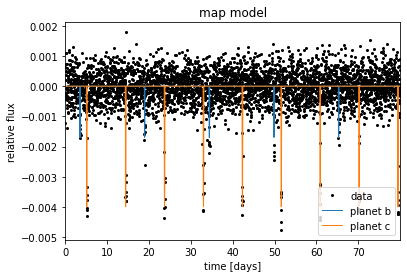

In [7]:
plt.plot(t, y, ".k", ms=4, label="data")
for i, l in enumerate("bc"):
    plt.plot(
        t, map_soln["light_curves"][:, i], lw=1, label="planet {0}".format(l)
    )
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
_ = plt.title("map model")

Sampling
Now, let’s sample from the posterior defined by this model. As usual, there are strong covariances between some of the parameters so we’ll use pmx.sample from pymc3-ext.

In [8]:
np.random.seed(42)
with model:
    trace = pmx.sample(
        tune=3000,
        draws=3000,
        start=map_soln,
        cores=2,
        chains=2,
        target_accept=0.9,
    )

/Users/josephkarpinski/opt/anaconda3/envs/env385exoplanet/lib/python3.8/site-packages/pymc3_ext/sampling/sampling.py:97: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return pm.sample(draws=draws, tune=tune, model=model, step=step, **kwargs)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, r, u, logP, t0, mean]


Sampling 2 chains for 3_000 tune and 3_000 draw iterations (6_000 + 6_000 draws total) took 138 seconds.


After sampling, it’s important that we assess convergence. We can do that using the pymc3.summary function:

In [9]:
import arviz as az

In [10]:
with model:
    summary = az.summary(
        trace, var_names=["period", "t0", "r", "b", "u", "mean"]
    )
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
period[0],15.448,0.002,15.443,15.452,0.000,0.000,2442.0,3119.0,1.0
period[1],9.292,0.000,9.292,9.293,0.000,0.000,4998.0,4351.0,1.0
t0[0],3.503,0.006,3.493,3.514,0.000,0.000,2439.0,3589.0,1.0
t0[1],5.121,0.001,5.119,5.124,0.000,0.000,5675.0,3893.0,1.0
r[0],0.040,0.002,0.037,0.043,0.000,0.000,2614.0,4152.0,1.0
r[1],0.058,0.001,0.057,0.060,0.000,0.000,2639.0,3380.0,1.0
b[0],0.669,0.048,0.573,0.739,0.001,0.001,2164.0,3051.0,1.0
b[1],0.404,0.037,0.336,0.469,0.001,0.001,2731.0,3345.0,1.0
u[0],0.379,0.212,0.000,0.723,0.003,0.002,3775.0,3599.0,1.0
u[1],0.266,0.344,-0.347,0.825,0.007,0.005,2550.0,3067.0,1.0


That looks pretty good! Fitting this without exoplanet would have taken a lot more patience.

Now we can also look at the corner plot of some of that parameters of interest:

/Users/josephkarpinski/opt/anaconda3/envs/env385exoplanet/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


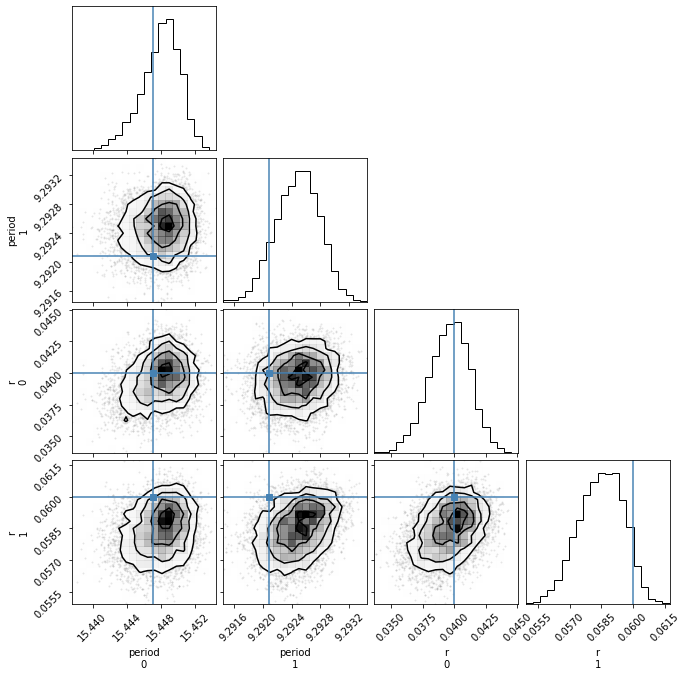

In [11]:
import corner

truth = dict(
    zip(
        ["period", "r"],
        pmx.eval_in_model([period, r], model.test_point, model=model),
    )
)
_ = corner.corner(
    trace,
    var_names=["period", "r"],
    truths=truth,
)

Phase plots
Like in the Radial velocity fitting tutorial, we can make plots of the model predictions for each planet.

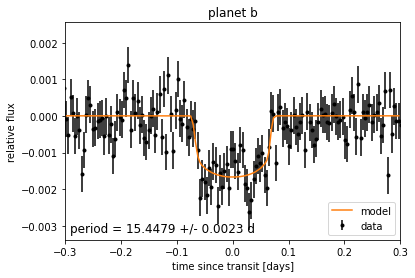

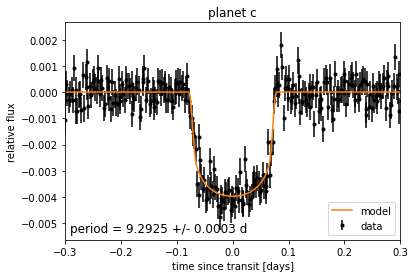

In [12]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    other = np.median(trace["light_curves"][:, :, (n + 1) % 2], axis=0)

    # Plot the folded data
    x_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(
        x_fold, y - other, yerr=yerr, fmt=".k", label="data", zorder=-1000
    )

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = trace["light_curves"][:, inds, n] + trace["mean"][:, None]
    pred = np.median(pred, axis=0)
    plt.plot(x_fold[inds], pred, color="C1", label="model")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n])
    )
    plt.annotate(
        txt,
        (0, 0),
        xycoords="axes fraction",
        xytext=(5, 5),
        textcoords="offset points",
        ha="left",
        va="bottom",
        fontsize=12,
    )

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("relative flux")
    plt.title("planet {0}".format(letter))
    plt.xlim(-0.3, 0.3)